 # Importing Required libraries

In [1]:
import numpy as np
import pandas as pd
import os
import zipfile
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import plotly.express as px
import random
from PIL import Image
import plotly.graph_objects as go
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


# Extracting the datasets

In [2]:
with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/train.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/train')
with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/test1.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/test')

# Setting up paths

In [3]:
train_dir = '/kaggle/working/train/train'
test_dir = '/kaggle/working/test/test1'

# Function to load and preprocess the images

In [4]:
def load_images(folder, img_size=(64, 64), sample_count=20, label_filter=None):
    images = []
    labels = []
    filenames = os.listdir(folder)
    
    if label_filter is not None:
        filenames = [fname for fname in filenames if label_filter in fname]
    
    random.shuffle(filenames)
    for img in filenames[:sample_count]:
        try:
            img_path = os.path.join(folder, img)
            img_pil = Image.open(img_path)
            img_pil = img_pil.resize(img_size)
            img_np = np.array(img_pil) / 255.0  # Normalize pixel values
            images.append(img_np)
            labels.append(0 if 'cat' in img else 1)
        except Exception as e:
            print(f"Error loading image {img}: {e}")
    
    return np.array(images), np.array(labels)

# Visualize images with labels

In [5]:
def visualize_images(images, labels, sample_count=20):
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))
    axes = axes.flatten()
    
    for i in range(sample_count):
        axes[i].imshow(images[i])
        axes[i].set_title('Cat' if labels[i] == 0 else 'Dog')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Load and visualize cat images

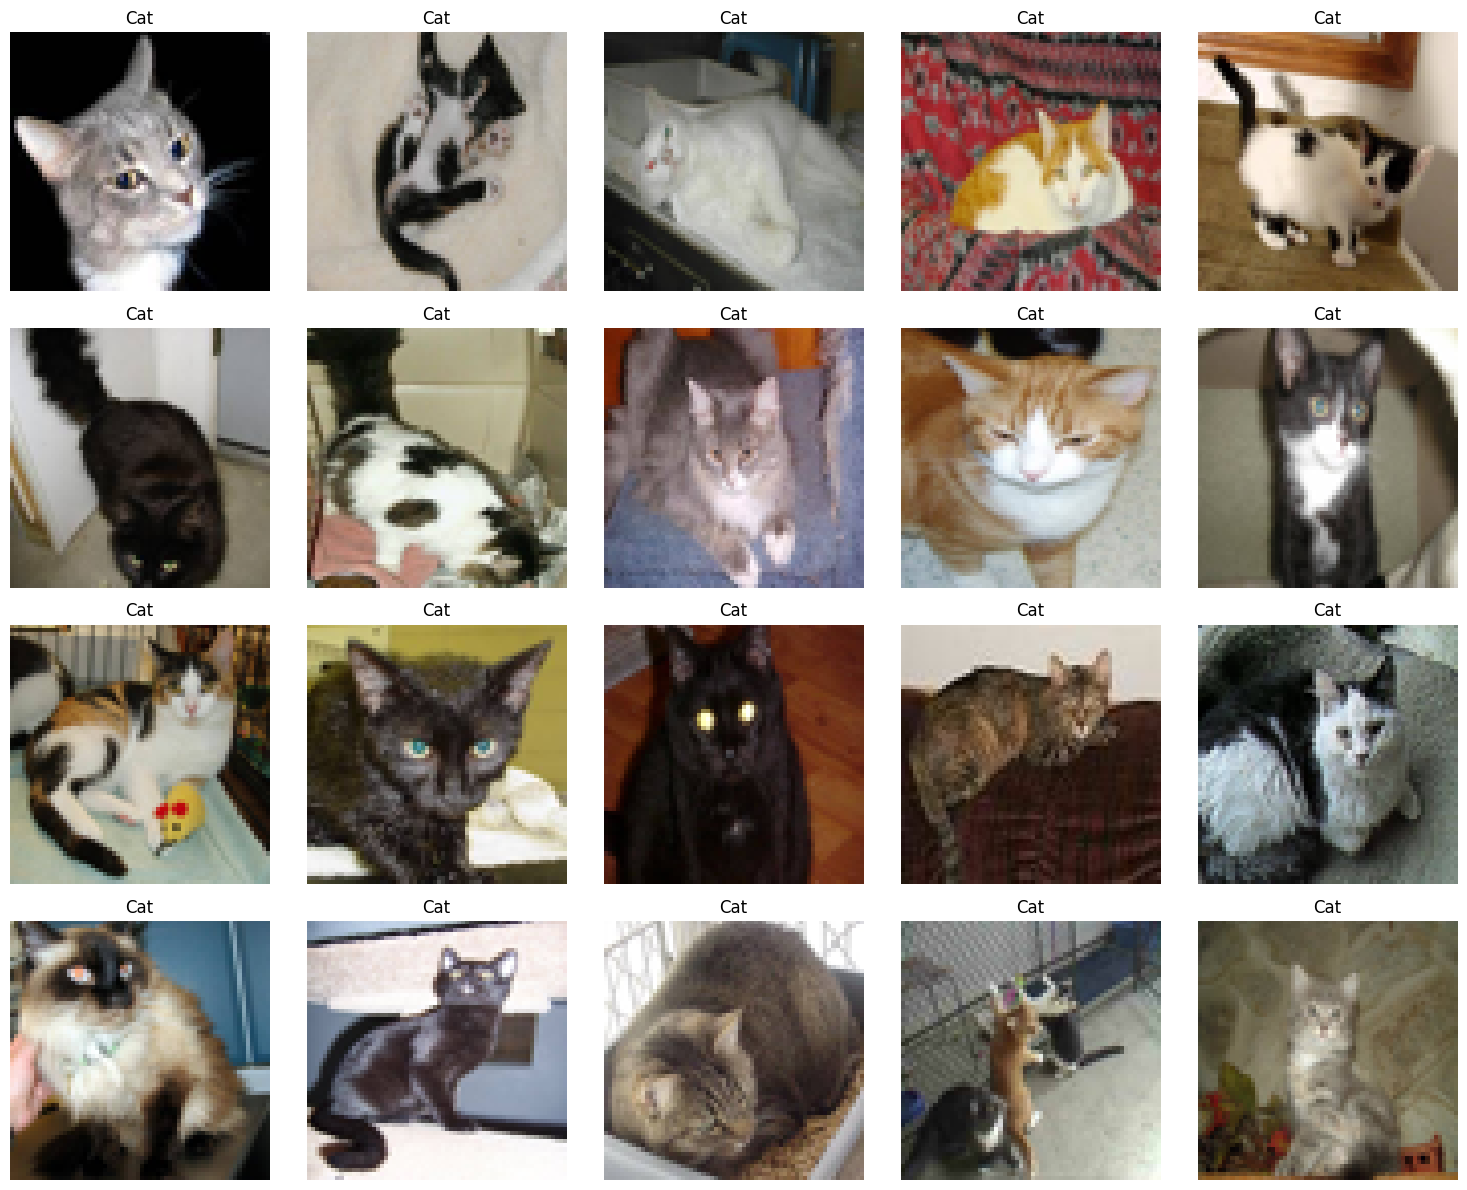

In [6]:
cat_images, cat_labels = load_images(train_dir, sample_count=20, label_filter='cat')
visualize_images(cat_images, cat_labels, sample_count=20)

# Load and visualize dog images

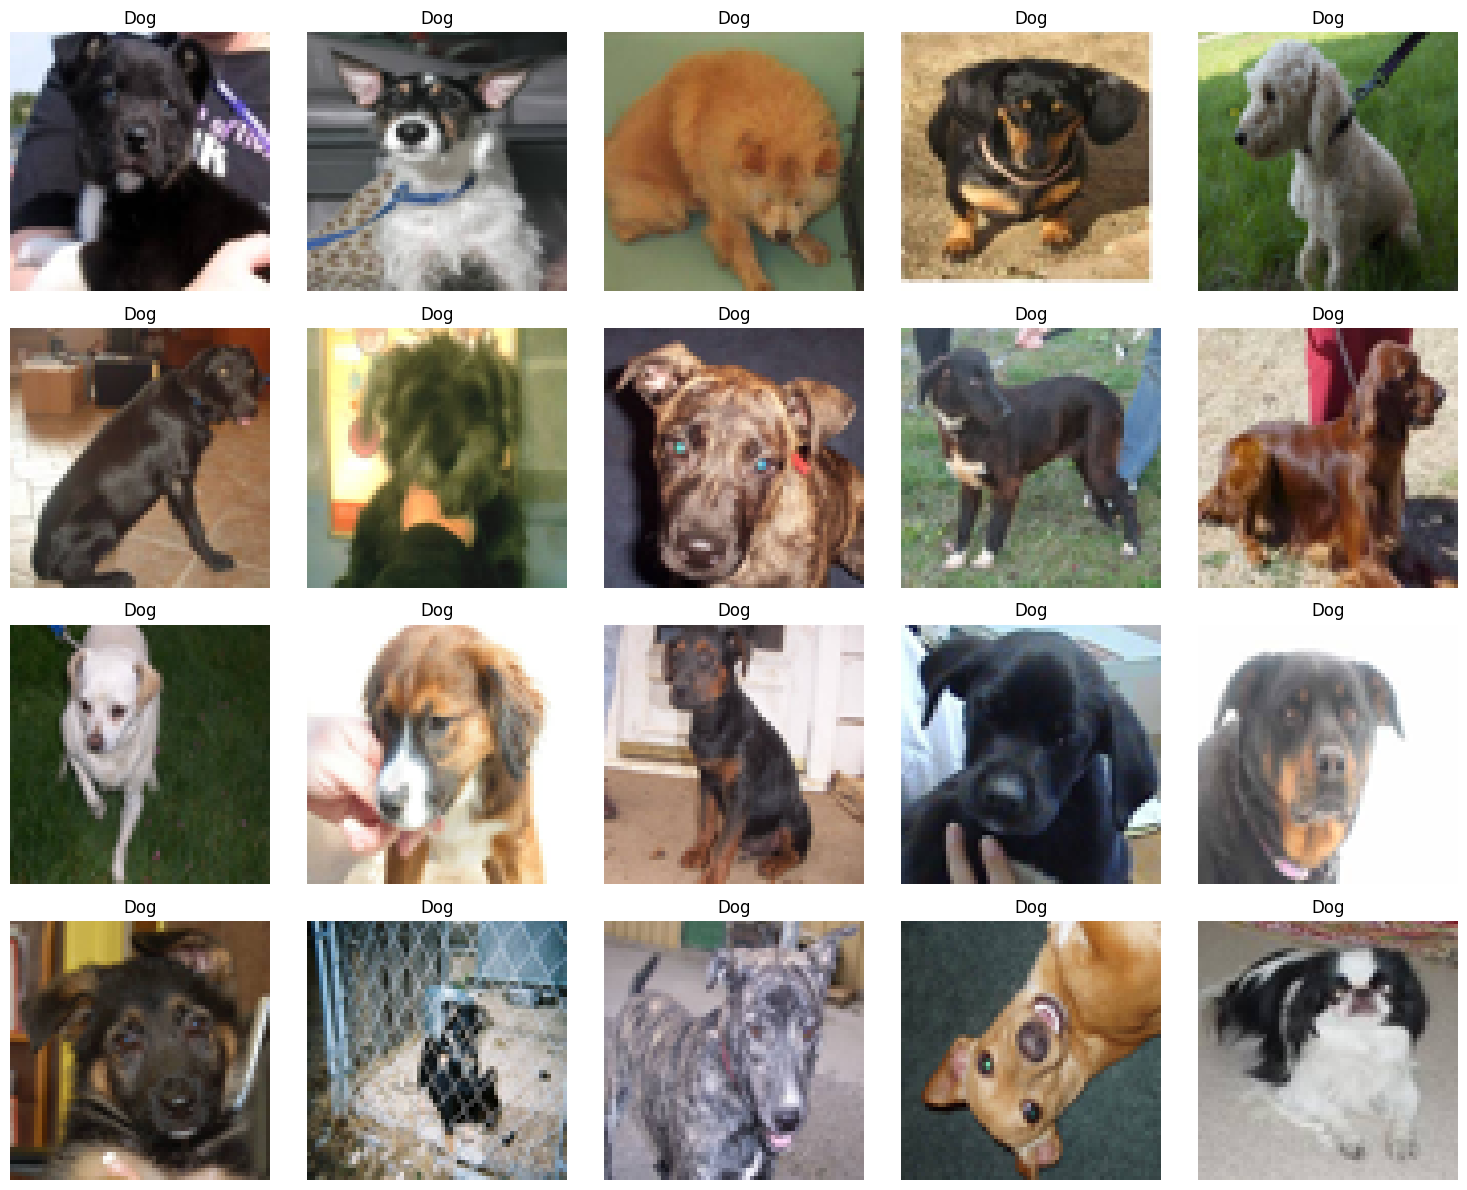

In [7]:
dog_images, dog_labels = load_images(train_dir, sample_count=20, label_filter='dog')
visualize_images(dog_images, dog_labels, sample_count=20)

# Load and visualize both cat and dog images

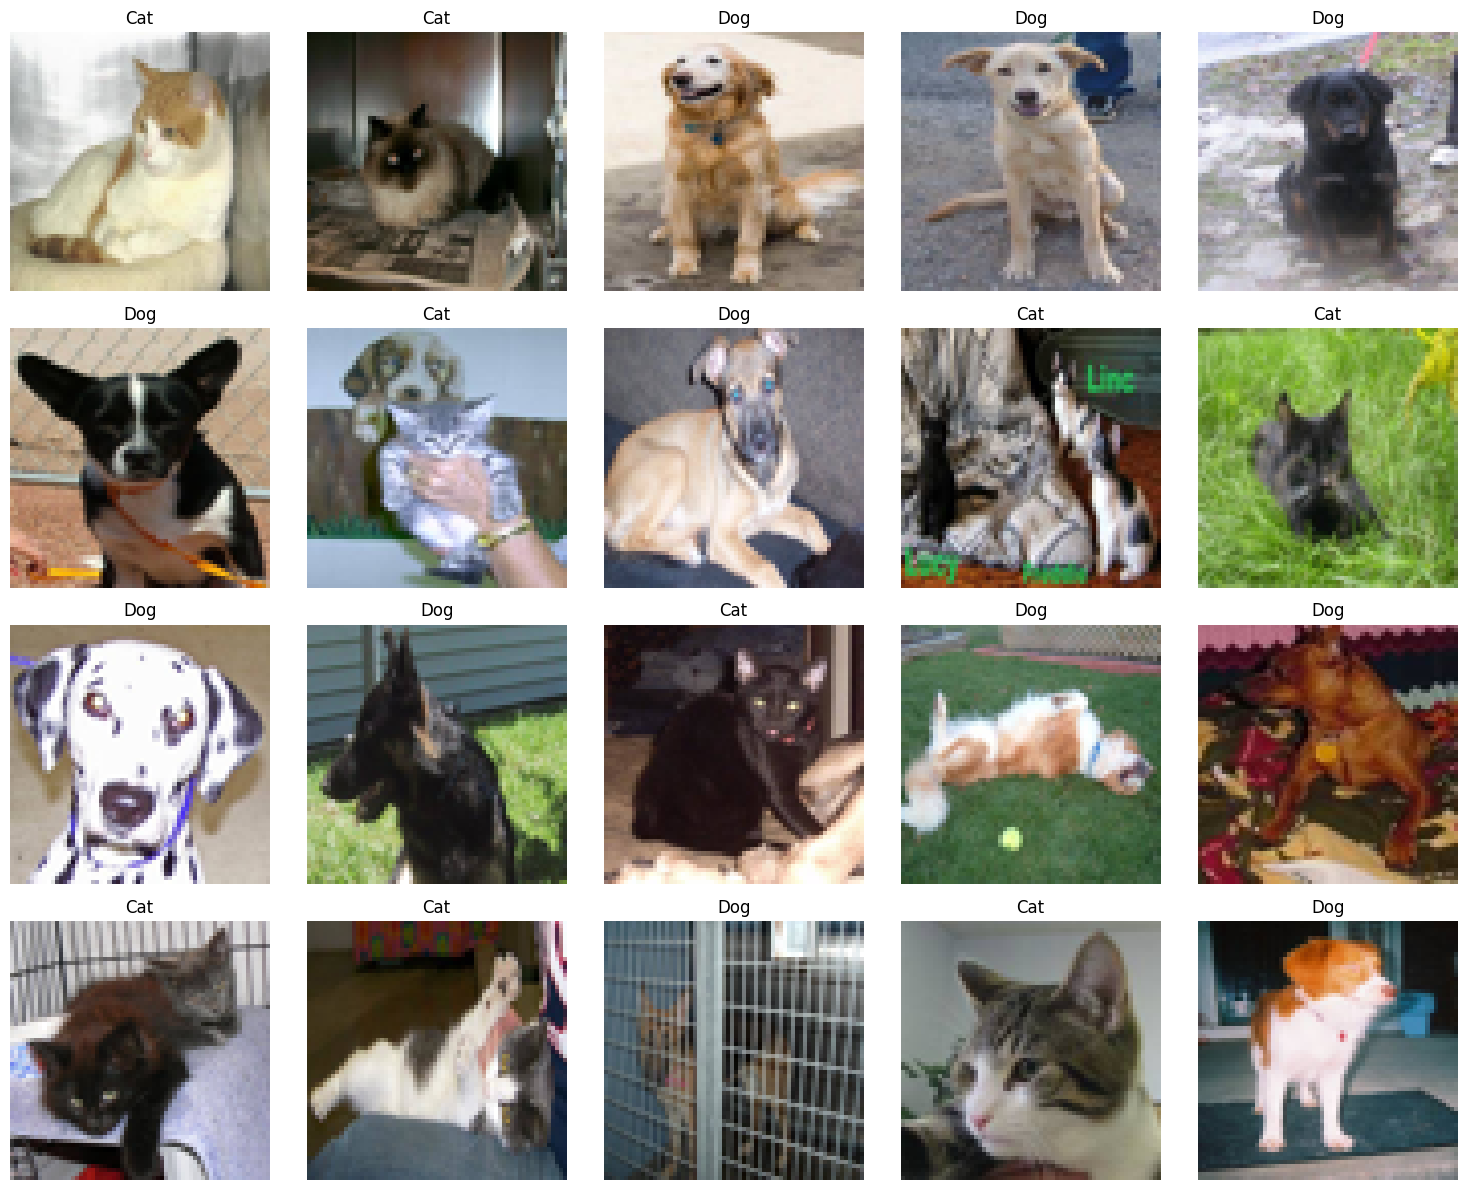

In [8]:
all_images, all_labels = load_images(train_dir, sample_count=20)
visualize_images(all_images, all_labels, sample_count=20)

# Loading and preprocessing the training data

In [9]:
images, labels = load_images(train_dir, sample_count=10000) 
images = images / 255.0

# Display the shape of the images array

In [10]:
print("Shape of images array:", images.shape)

Shape of images array: (10000, 64, 64, 3)


# Display the shape of the first image

In [11]:
print("Shape of the first image:", images[0].shape)

Shape of the first image: (64, 64, 3)


 # Display the first 2 images

In [12]:
print(images[:2]) 
print(labels[:2])

[[[[2.79892349e-03 2.72202999e-03 2.67589389e-03]
   [2.93733180e-03 2.86043829e-03 2.81430219e-03]
   [2.90657439e-03 2.82968089e-03 2.78354479e-03]
   ...
   [3.67550942e-03 3.67550942e-03 3.67550942e-03]
   [3.70626682e-03 3.70626682e-03 3.70626682e-03]
   [3.73702422e-03 3.73702422e-03 3.75240292e-03]]

  [[2.81430219e-03 2.73740869e-03 2.69127259e-03]
   [2.96808920e-03 2.89119569e-03 2.84505959e-03]
   [2.93733180e-03 2.86043829e-03 2.81430219e-03]
   ...
   [3.67550942e-03 3.67550942e-03 3.67550942e-03]
   [3.70626682e-03 3.70626682e-03 3.70626682e-03]
   [3.72164552e-03 3.72164552e-03 3.73702422e-03]]

  [[2.81430219e-03 2.73740869e-03 2.69127259e-03]
   [2.98346790e-03 2.90657439e-03 2.86043829e-03]
   [2.93733180e-03 2.86043829e-03 2.81430219e-03]
   ...
   [3.67550942e-03 3.67550942e-03 3.67550942e-03]
   [3.70626682e-03 3.70626682e-03 3.73702422e-03]
   [3.70626682e-03 3.70626682e-03 3.73702422e-03]]

  ...

  [[3.41407151e-03 3.29104191e-03 3.29104191e-03]
   [3.38331411e-

# Flattening the images for the SVM input

In [13]:
n_samples, img_height, img_width, img_channels = images.shape
images_flat = images.reshape(n_samples, -1)

# Standardizing the features

In [14]:
scaler = StandardScaler()
images_flat_scaled = scaler.fit_transform(images_flat)

# Applying t-SNE 

In [15]:
perplexity = min(30, n_samples - 1)
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
images_tsne = tsne.fit_transform(images_flat_scaled)

# Splitting the dataset into training and test sets

In [16]:
X_train, X_val, y_train, y_val = train_test_split(images_flat_scaled, labels, test_size=0.2, random_state=42)

In [17]:
X_train

array([[ 1.94658189,  2.02324302,  2.09386241, ...,  1.88867951,
         1.90131172, -0.25522414],
       [ 1.24187959,  1.47383885,  1.61309302, ...,  0.25352038,
         0.44137615,  0.47575037],
       [ 0.72413913,  0.85214466,  0.96264031, ...,  0.38610085,
         0.38117262,  0.34417496],
       ...,
       [ 0.99739104,  0.02803841, -0.53622897, ...,  1.12265901,
         1.13371673,  1.10438845],
       [ 0.66661242,  0.51961056,  0.35460843, ...,  0.10620874,
         0.41127439,  0.66580375],
       [-1.11671584, -1.04185392, -1.1159803 , ...,  0.94588505,
        -0.94330501, -0.47451649]])

In [18]:
X_val

array([[-0.21067003, -0.3189537 , -0.50794842, ..., -0.54196245,
        -0.1907609 , -0.85462324],
       [-0.84346393, -0.6370298 , -0.3382651 , ..., -0.18841453,
        -0.20581178,  0.19798006],
       [ 0.47965058,  0.83768666,  0.83537783, ...,  0.93115389,
         1.20897114,  1.20672489],
       ...,
       [-1.13109752, -1.07076993, -0.90387615, ..., -1.73518668,
        -1.62059471, -1.42478336],
       [ 1.18435288,  1.15576275,  1.01920142, ...,  1.26997065,
         1.28422555,  1.10438845],
       [ 1.52951318,  0.70756462,  0.28390705, ..., -1.13120898,
        -1.21422089, -1.22011049]])

In [19]:
X_val

array([[-0.21067003, -0.3189537 , -0.50794842, ..., -0.54196245,
        -0.1907609 , -0.85462324],
       [-0.84346393, -0.6370298 , -0.3382651 , ..., -0.18841453,
        -0.20581178,  0.19798006],
       [ 0.47965058,  0.83768666,  0.83537783, ...,  0.93115389,
         1.20897114,  1.20672489],
       ...,
       [-1.13109752, -1.07076993, -0.90387615, ..., -1.73518668,
        -1.62059471, -1.42478336],
       [ 1.18435288,  1.15576275,  1.01920142, ...,  1.26997065,
         1.28422555,  1.10438845],
       [ 1.52951318,  0.70756462,  0.28390705, ..., -1.13120898,
        -1.21422089, -1.22011049]])

In [20]:
y_val

array([1, 0, 0, ..., 0, 1, 0])

# Checking class distribution

In [21]:
unique, counts = np.unique(labels, return_counts=True)
print(f"Class distribution: {dict(zip(unique, counts))}")

Class distribution: {0: 5064, 1: 4936}


In [22]:
def plot_tsne_data(tsne_data, labels, title):
    df_tsne = pd.DataFrame()
    df_tsne['X'] = tsne_data[:, 0]
    df_tsne['Y'] = tsne_data[:, 1]
    df_tsne['Label'] = labels
    df_tsne['Label'] = df_tsne['Label'].map({0: 'Cat', 1: 'Dog'})
    
    fig = px.scatter(df_tsne, x='X', y='Y', color='Label', title=title)
    fig.show()

plot_tsne_data(images_tsne, labels, 't-SNE visualization of Cats vs Dogs')

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


# Training the SVM model

In [23]:
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

SVC(kernel='linear')

# Making predictions on the validation set

In [24]:
y_val_pred = svm.predict(X_val)

In [25]:
y_val_pred

array([0, 1, 0, ..., 0, 0, 1])

# Evaluating the model

In [26]:
val_accuracy = accuracy_score(y_val, y_val_pred)
val_class_report = classification_report(y_val, y_val_pred, target_names=['Cat', 'Dog'])
val_conf_matrix = confusion_matrix(y_val, y_val_pred)

# Accuracy

In [27]:
print(f'Validation Accuracy: {val_accuracy:.4f}')

Validation Accuracy: 0.5585


# Classification Report

In [28]:
print('Validation Classification Report:')
print(val_class_report)

Validation Classification Report:
              precision    recall  f1-score   support

         Cat       0.56      0.61      0.58      1009
         Dog       0.56      0.50      0.53       991

    accuracy                           0.56      2000
   macro avg       0.56      0.56      0.56      2000
weighted avg       0.56      0.56      0.56      2000



# Confusion Matrix

Validation Confusion Matrix:
[[617 392]
 [491 500]]


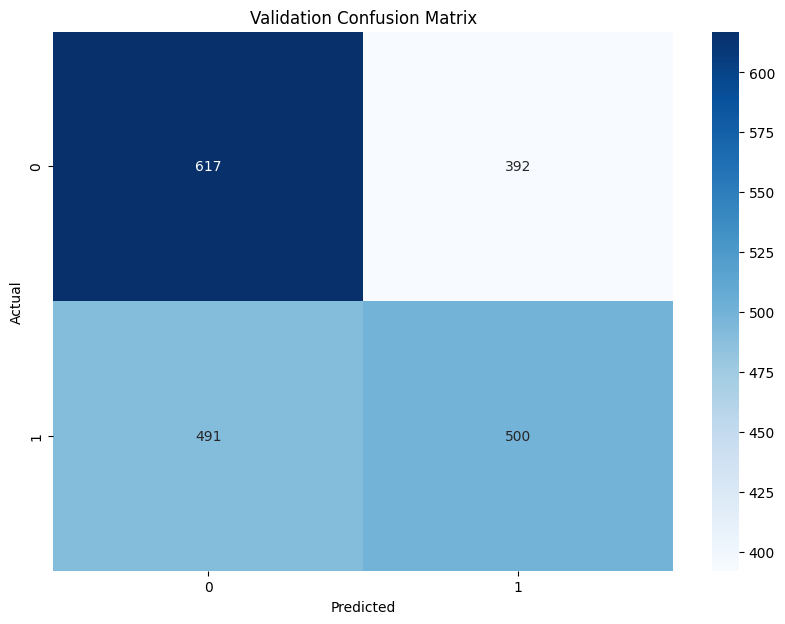

In [29]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
print('Validation Confusion Matrix:')
print(val_conf_matrix)
plt.figure(figsize=(10, 7))
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Validation Confusion Matrix')
plt.show()


# Saving the SVM model and scaler

In [30]:
import pickle
with open('/kaggle/working/svm_model.pkl', 'wb') as f:
    pickle.dump(svm, f)
with open('/kaggle/working/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Loading and preprocessing the test data

In [31]:
test_images, test_labels = load_images(test_dir)  
test_images = test_images / 255.0

# Flattening the test images for the SVM input

In [32]:
n_test_samples, test_img_height, test_img_width, test_img_channels = test_images.shape
test_images_flat = test_images.reshape(n_test_samples, -1)
test_images_flat_scaled = scaler.transform(test_images_flat)

# Standardizing the test features

In [33]:
test_images_flat_scaled = scaler.transform(test_images_flat)

# Applying t-SNE for visualization on test data

In [34]:
# Determine a new perplexity value for the test data
test_perplexity = min(30, n_test_samples - 1)

# Create a new t-SNE instance for the test data
test_tsne = TSNE(n_components=2, perplexity=test_perplexity, random_state=42)
test_images_tsne = test_tsne.fit_transform(test_images_flat_scaled)

# Making predictions on the test set

In [35]:
y_test_pred = svm.predict(test_images_flat_scaled)

In [36]:
y_test_pred

array([0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0])

# Creating a DataFrame for Plotly

In [37]:
df_test_tsne = pd.DataFrame()
df_test_tsne['X'] = test_images_tsne[:, 0]
df_test_tsne['Y'] = test_images_tsne[:, 1]
df_test_tsne['Predicted Label'] = y_test_pred
df_test_tsne['Predicted Label'] = df_test_tsne['Predicted Label'].map({0: 'Cat', 1: 'Dog'})


# Plotting with Plotly

In [38]:
fig = px.scatter(df_test_tsne, x='X', y='Y', color='Predicted Label', title='t-SNE visualization of Test Data Predictions')
fig.show()

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



# Visualizing some of the test results with Plotly

In [39]:
def plot_test_samples(images, tsne_data, predictions, sample_count=10):
    sample_indices = np.random.choice(range(len(images)), sample_count, replace=False)
    sample_images = images[sample_indices]
    tsne_samples = tsne_data[sample_indices]
    pred_samples = predictions[sample_indices]

    fig = px.scatter(tsne_samples, x=tsne_samples[:, 0], y=tsne_samples[:, 1], color=pred_samples.astype(str),
                     title="Test Data Predictions (t-SNE Space)")
    fig.show()

plot_test_samples(test_images, test_images_tsne, y_test_pred)

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



# Saving the test predictions to a CSV file

In [40]:
test_predictions = pd.DataFrame({'Id': np.arange(1, n_test_samples + 1), 'Label': y_test_pred})
test_predictions['Label'] = test_predictions['Label'].map({0: 'Cat', 1: 'Dog'})
test_predictions.to_csv('/kaggle/working/test_predictions.csv', index=False)

In [41]:
def plot_samples(tsne_data, y_true, y_pred, sample_count=10):
    sample_indices = np.random.choice(range(len(tsne_data)), sample_count, replace=False)
    tsne_samples = tsne_data[sample_indices]
    y_true_samples = y_true[sample_indices]
    y_pred_samples = y_pred[sample_indices]

    df_tsne_samples = pd.DataFrame()
    df_tsne_samples['X'] = tsne_samples[:, 0]
    df_tsne_samples['Y'] = tsne_samples[:, 1]
    df_tsne_samples['True Label'] = y_true_samples
    df_tsne_samples['Predicted Label'] = y_pred_samples
    df_tsne_samples['True Label'] = df_tsne_samples['True Label'].map({0: 'Cat', 1: 'Dog'})
    df_tsne_samples['Predicted Label'] = df_tsne_samples['Predicted Label'].map({0: 'Cat', 1: 'Dog'})

    fig = px.scatter(df_tsne_samples, x='X', y='Y', color='True Label', symbol='Predicted Label', title="True vs Predicted Labels (t-SNE Space)")
    fig.show()

# Apply t-SNE to the validation data
val_tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
val_images_tsne = val_tsne.fit_transform(X_val)

# Plot true vs predicted labels for the validation set
plot_samples(val_images_tsne, y_val, y_val_pred)


# Thank You!